# Demonstration & Explanations of Image Complexity Metrics

This notebook will demonstrate several calculations used to estimate the degree of complexity that an image possesses.

The metrics documented here will be used to sort images based on their calculated complexity. In doing so, we may implement a curriculum by which a neural network can train on said images, such that they extract features in a manner more efficient than training on randomly shuffled images.

## Table of Contents:
* [Generating Sample Images](#sample-images)
* Metrics
    * [Wavelet Energy](#wavelet-energy)
    * [Wavelet Entropy](#wavelet-entropy)
    * [Root Mean Squared Error](#root-mean-squared-error)
    * [Spatial Frequency](#spatial-frequency)
    * [Texture Complexity](#texture-complexity)
    * [Edge Density](#edge-density)
    * [Fractal Dimensions](#fractal-dimensions)

---

## Sample Images

First, we need images that we can reasonably say are more/less complex than each other. For this purpose we will generate 6 black and white images. One solid black, one solid white, a 2x2 checker board, 4x4, 8x8, and 16x16.

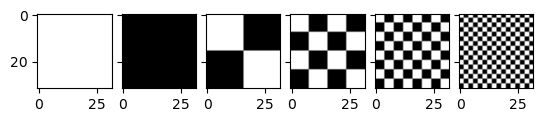

In [15]:
"""Generate sample images."""

from PIL                        import Image
from matplotlib                 import cm, pyplot as plt
from mpl_toolkits.axes_grid1    import ImageGrid

# Initialize images dictionary
images: dict[str, any]  = {}

# Create solid black & white images
images.update({"white": Image.new("L", (32, 32), 255)})
images.update({"black": Image.new("L", (32, 32), 0)})

# Create checkered images
for e in range(1, 5):
    
    # Determine size of each square
    square_dim: int     = 32 // 2**e
    
    # Initialize image
    img:        Image   = Image.new("L", (32, 32))
    
    # Color the image
    for x in range(32):
        for y in range(32):
            img.putpixel((x, y), 255 if ((x // square_dim) + (y // square_dim)) % 2 == 0 else 0)
            
    # Add to dictionary
    images.update({f"{2**e}x{2**e}": img})

# Initialize plot
figure  = plt.figure()

# Initialize grid
grid    = ImageGrid(figure, 111, nrows_ncols = (1, 6), axes_pad  = 0.1)

# Add images to grid
for axis, image in zip(grid, images.values()): axis.imshow(image, cmap = cm.gray, vmin = 0, vmax = 255)

# Diplsay images
plt.show()

---

# Wavelet Energy

The wavelet transform is a mathematical technique that decomposes a signal into components at various scales and positions, allowing for the analysis of both frequency and time domain characteristics simultaneously. 

Unlike the Fourier transform, which only provides frequency information and loses temporal localization, the wavelet transform offers the advantage of capturing localized, transient features of a signal. This makes it particularly useful for analyzing non-stationary signals, such as images, where details and patterns vary across different regions. The ability to provide multi-resolution analysis makes the wavelet transform a powerful tool for image processing~\cite{bayro2005multi}, enabling better detection of edges, textures, and other intricate structures compared to the Fourier transform.

Given an image $I$, a wavelet $w$, and decomposition level $l$:
* Perform the 2D wavelet decomposition: $\text{wavedec2}(I, w, l)$.
* For each coefficient matrix $\text{coeff}_i$, calculate the energy: $E_i = \sum_{j, k} \text{coeff}_i[j, k]^2$.
* Sum the energy of all coefficient matrices to get the total wavelet energy: $\sum_i E_i$.

$$
E = \sum_{i} \sum_{j,k} \left( \text{coeff}_i[j,k] \right)^2
$$

Reference(s):
* [Decomposition of Hardy Functions into Square Integrable Wavelets of Constant Shape](https://epubs.siam.org/doi/10.1137/0515056)

In [13]:

"""Define & calculate wavelet energy of sample images."""

from numpy  import abs, array, log2, square, sum
from pywt   import wavedec2, wavelist

import pywt

def wavelet_energy(
        image:      array, 
        wavelet:    str = "db2", 
        level:      int = 1,
        mode:       str = "periodization"
    ) -> int:
    """# Calculate the wavelet energy of an image.

    ## Args:
        * image     (array):            Image for which the wavelet energy will be calculated.
        * wavelet   (str, optional):    Wavelet used in transform. Defaults to 'db2'.
        * level     (int, optional):    Level(s) of decomposition to perform. Defaults to 1.
        * mode      (str, optional):    Mode of padding. Options: 'zero', 'constant', 'symmetric', 
                                        'periodic', 'smooth', 'periodization', 'reflect', 
                                        'antisymmetric', 'antireflect'. Defaults to 'periodization'.

    ## Returns:
        * int:  Wavelet energy of image.
    """
    # Validate wavelet & mode arguments
    assert wavelet in wavelist(),       f"Invalid argument for wavelet: {wavelet}. Valid options: {wavelist()}"
    assert mode in pywt.Modes.modes,    f"Inavlid argument for mode: {mode}. Valid options: {pywt.Modes.modes}"

    # Calculate energy
    return sum([sum(square(coeff)) for coeff in wavedec2(image, wavelet=wavelet, level=level, mode=mode)])

# Calculate wavelet energy of samples
for name, image in images.items(): print(f"Wavelet evergy of {name:5}: {wavelet_energy(image):20.9f}")

Wavelet evergy of white:   66585600.000000007
Wavelet evergy of black:          0.000000000
Wavelet evergy of 2x2  :   33292800.000000015
Wavelet evergy of 4x4  :   33292800.000000011
Wavelet evergy of 8x8  :   33292800.000000011
Wavelet evergy of 16x16:   33292800.000000004


---

# Wavelet Entropy

Wavelet entropy, specifically Shannon entropy, is computed by first obtaining the wavelet coefficients of an image. These coefficients are then used to calculate the probability distribution of energy across different scales. Shannon entropy is derived from this distribution, providing a measure of the image's complexity and randomness by quantifying the degree of disorder or unpredictability in the energy distribution.

Given an image $I$, wavelet $w$, and decomposition level $l$:
* Perform the 2D wavelet decomposition: $\text{wavedec2}(I, w, l)$.
* Flatten and take the absolute value of all coefficients: $\text{coefficients} = \left| \text{coeff}_i[j, k]\right|$.
* Normalize the coefficients to obtain probabilities: $p_i = \frac{\text{coefficients} + \epsilon}{\sum_j \text{coefficients}_j + \epsilon}$.
* Calculate the Shannon entropy as follows, where $\epsilon$ is a small value added to avoid taking the log of zero
$$
H = -\sum_i p_i \log_2(p_i + \epsilon)
$$

Reference(s):
* [Wavelet entropy: a new tool for analyzing time-series](https://www.researchgate.net/publication/12164427_Wavelet_entropy_A_new_tool_for_analysis_of_short_duration_brain_electrical_signals)

In [12]:
"""Define & calculate wavelet entropy of sample images."""

from math   import e
from numpy  import abs, array, finfo, log2, square, sum
from pywt   import wavedec2

def wavelet_entropy(
        image:      array, 
        wavelet:    str = "db2", 
        level:      int = 1,
        mode:       str = "periodization"
    ) -> float:
    """# Calculate the wavelet entropy of an image.

    ## Args:
        * image     (array):            Image for which the wavelet energy will be calculated.
        * wavelet   (str, optional):    Wavelet used in transform. Defaults to 'db2'.
        * level     (int, optional):    Level(s) of decomposition to perform. Defaults to 1.
        * mode      (str, optional):    Mode of padding. Options: 'zero', 'constant', 'symmetric', 
                                        'periodic', 'smooth', 'periodization', 'reflect', 
                                        'antisymmetric', 'antireflect'. Defaults to 'periodization'.

    ## Returns:
        * float:    Wavelet entropy of image.
    """
    # Initialize arrays to store all coefficients
    coefficients = []

    # For each level of coefficients computed...
    for coefficient in wavedec2(data = image, wavelet = wavelet, level = level, mode = mode):

        # Add their absolute values to the list
        coefficients.extend(abs(coefficient).ravel())

    # Convert them to an array
    coefficients = array(coefficients)
    
    # Normalize coefficients to probabilities
    probabilities = (coefficients + e) / (sum(coefficients) + e)
    
    # Return computed Shannon entropy
    return -sum(probabilities * log2(probabilities + finfo(float).eps))

# Calculate wavelet entropy of samples
for name, image in images.items(): print(f"Wavelet entropy of {name:5}: {wavelet_entropy(image):20.9f}")

Wavelet entropy of white:          8.283457315
Wavelet entropy of black:         -0.000000000
Wavelet entropy of 2x2  :          8.302744113
Wavelet entropy of 4x4  :          8.819395636
Wavelet entropy of 8x8  :          9.526450731
Wavelet entropy of 16x16:         10.029552916


---

# Root Mean Squared Error

RMSE has seen great success in measuring visual complexity in humans, and its speed makes it an ideal and intuitive choice for measuring image complexity. Root Mean Square Error in this case refers to the difference between the original image and the image after shrinking it by half, resizing it back to full size, computing the average of the squared pixel values of the difference, then taking the square root.

Given an image $I$ with dimensions $(H, W)$:


* Let $I_{\text{small}}$ be the image resized to $(\frac{H}{2}, \frac{W}{2})$.
* Let $I_{\text{resized}}$ be $I_{\text{small}}$ resized back to $(H, W)$.
* Compute the element-wise squared difference: $(I - I_{\text{resized}})^2$.
* Compute the mean of the squared differences.
* The $RMSE$ is then the square root of the mean.

$$
RMSE = \sqrt{\frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} \left( I_{ij} - I_{\text{resized}, ij} \right)^2}
$$

Reference(s):
* [Spatial Frequency Analysis in the Visual System](https://www.cns.nyu.edu/~shapley/Publications/Shapley-Lennie1985.pdf)

In [11]:
"""Define & calculate root mean squared error of sample images."""

from numpy  import array, asarray, mean, ndarray, sqrt

def rmse(image: ndarray) -> float:
    """# Calculates the root mean squared error between an image and it's compressed/resized form.

    ## Args:
        * image (array):    Image input.

    ## Returns:
        * float:    Root mean squared error.
    """
    # Record image shape
    shape:  tuple = array(image).shape
    
    # Calculate & return RMSE
    return sqrt(mean(
        (image - asarray(
            image.resize((shape[1] // 2, shape[0] // 2)).resize((shape[1], shape[0]))
        )) ** 2
    ))

# Calculate root mean squared error of samples
for name, image in images.items(): print(f"Root mean squared error of {name:5}: {rmse(image):20.9f}")

Root mean squared error of white:          0.000000000
Root mean squared error of black:          0.000000000
Root mean squared error of 2x2  :          3.593070588
Root mean squared error of 4x4  :          4.577458356
Root mean squared error of 8x8  :          7.370231509
Root mean squared error of 16x16:          8.806957477


---

# Spatial Frequency

Spatial Frequency is unique from the other metrics we used in that it does not rely on edges or borders, but on a Fourier Analysis of an image. Although a contested topic and a rudimentary metric for calculating organic visual perception, the function's speed and unique properties make it a considerable choice for an experimental metric.

Given an image $I$ with dimensions $(H, W, 3)$:
* Convert the image to grayscale $I_{\text{gray}}$.
* Compute the 2D Fourier transform of the grayscale image $\mathcal{F}(I_{\text{gray}})$.
* Compute the 2D Fourier transform of each RGB channel $\mathcal{F}(I_{\text{R}})$, $\mathcal{F}(I_{\text{G}})$, $\mathcal{F}(I_{\text{B}})$.
* The spatial frequency will be the sum of the absolute values of the 2D Fourier transforms.

$$
\text{SF} = \left| \mathcal{F}(I_{\text{gray}}) \right| + \left| \mathcal{F}(I_{\text{R}}) \right| + \left| \mathcal{F}(I_{\text{G}}) \right| + \left| \mathcal{F}(I_{\text{B}}) \right|
$$

Reference(s):
* [Spatial Frequency and the Performance of Image-Based Visual Complexities](https://ieeexplore.ieee.org/iel7/6287639/6514899/09103062.pdf)

In [9]:
"""Define & calculate spatial frequency of sample images."""

from numpy      import abs, asarray, ndarray, sum
from numpy.fft  import fft2
from PIL        import Image

def spatial_frequency(image: ndarray) -> float:
    """# Calculate the spatial frequency of an image.

    ## Args:
        * image (ndarray):  Image input.

    ## Returns:
        * float:    Spatial frequency of image channels (gray, red, green, blue).
    """
    # Calculate Fourier transform of each channel
    return sum([
        abs(fft2(asarray(Image.fromarray(asarray(image)).convert("L")))),
        # abs(fft2(image[:, :, 0])),
        # abs(fft2(image[:, :, 1])),
        # abs(fft2(image[:, :, 2]))
    ])

# Calculate spatial frequency of samples
for name, image in images.items(): print(f"Spatial frequency of {name:5}: {spatial_frequency(image):20.9f}")

Spatial frequency of white:     261120.000000000
Spatial frequency of black:          0.000000000
Spatial frequency of 2x2  :    1102027.253736808
Spatial frequency of 4x4  :     813446.572458933
Spatial frequency of 8x8  :     576319.722703431
Spatial frequency of 16x16:     391680.000000000


---

# Texture Complexity

*Enter description*

*Enter steps taken in algorithm and the formal mathematical definition*

In [44]:
"""Define & calculate texture complexity of sample images."""

from numpy  import ndarray

def texture_complexity(
    image:  ndarray
) -> int:
    """# _summary_

    ## Args:
        * image (ndarray):  _description_

    ## Returns:
        * int:  _description_
    """
    # Implement calculation of texture complexity

# Calculate texture complexity of samples
for name, image in images.items(): print(f"Texture complexity of {name:5}: {texture_complexity(image):20.9f}")

TypeError: unsupported format string passed to NoneType.__format__

---

# Edge Density

Edge density is proposed to be the ratio of pixels within an image that contribute to the formation of lines/edges, divided by the number of pixels that do no contribute to forming lines/edges.

*Enter description*

*Enter steps taken in algorithm and the formal mathematical definition*

In [8]:
"""Define & calculate edge density of sample images."""

from numpy  import ndarray

def edge_density(
    image:  ndarray
) -> int:
    """# _summary_

    ## Args:
         *image (ndarray):  _description_

    ## Returns:
        * int:  _description_
    """
    # Implement calculation of edge density

# Calculate edge density of samples
for name, image in images.items(): print(f"Edge density of {name:5}: {edge_density(image):20.9f}")

TypeError: unsupported format string passed to NoneType.__format__

---

# Fractal Dimensions

Fractal dimensions are used to quantify the complexity of a shape, pattern, or image, particularly in fractals or naturally complex patterns. For an image, the box-counting method is a common approach to calculate its fractal dimension.

Let $I$ be a 2D binary image where the foreground pixels represent the shape or structure we are analyzing, and the background pixels are zero-valued. The box-counting method consists of the following steps:

* Convert the Image to Binary:
    If the image $I$ is grayscale, it is first converted into a binary image. This is done by applying a threshold $T$ to the grayscale image:
    $$
    I_{\text{binary}}(x, y) =
    \begin{cases}
    1 & \text{if } I(x, y) < T, \\
    0 & \text{if } I(x, y) \geq T,
    \end{cases}
    $$
    
    where $I(x, y)$ is the grayscale intensity of the pixel at position $(x, y)$, and $T$ is the chosen threshold.

* Overlay a Grid of Boxes
    A grid of boxes of size $\epsilon \times \epsilon$ is placed over the image. For each grid size, count the number of boxes that contain at least one pixel from the foreground (non-zero pixels in $I_{\text{binary}}$). Denote this count as $N(\epsilon)$.

* Vary the Size of the Grid
    Repeat Step 2 for progressively smaller box sizes $\epsilon$. Typically, $\epsilon$ values are chosen as powers of 2 (e.g., $\epsilon = 2^k, k = 1, 2, 3, \dots$) to ensure a uniform grid division.

* Compute the Fractal Dimension

    * The fractal dimension $D$ is defined by the scaling relationship between $N(\epsilon)$ and the box size $\epsilon$:
        $$
        D = \lim_{\epsilon \to 0} \frac{\log N(\epsilon)}{\log (1/\epsilon)}.
        $$

    * In practice, $D$ is estimated by plotting $\log N(\epsilon)$ against $\log(1/\epsilon)$ and finding the slope of the linear portion of the plot:
        $$
        D \approx -\frac{\Delta \log N(\epsilon)}{\Delta \log \epsilon}.
        $$

### Formal mathematical definition:

$$
D = \lim_{\epsilon \to 0} \frac{\log N(\epsilon)}{\log(1/\epsilon)}
$$

where:

* $N(\epsilon)$ is the number of boxes of size $\epsilon \times \epsilon$ that contain part of the structure (i.e., boxes containing at least one foreground pixel),
* $\epsilon$ is the side length of each box in the grid,
* $\log$ is the natural logarithm.

Reference(s):
* [Fractals, fractal dimensions and landscapes a review](https://www.researchgate.net/profile/Tingbao-Xu/publication/238379119_Fractals_fractal_dimensions_and_landscapes_---_a_review/links/5b47e95e45851519b4b46ae2/Fractals-fractal-dimensions-and-landscapes---a-review.pdf)

In [7]:
"""Define & calculate fractal dimensions of sample images."""

from numpy  import add, arange, asarray, count_nonzero, log, logspace, log2, ndarray, polyfit

def fractal_dimensions(
    image:      ndarray, 
    threshold:  int     = 128
) -> float:

    # Convert image to binary
    binary_image:   ndarray = (image < threshold)

    # Sizes of the boxes (powers of 2)
    sizes:          ndarray = logspace(1, log2(min(image.shape)), num=10, base=2).astype(int)

    # Initialize counts list
    counts:         list    = []
    
    # For each size
    for size in sizes:

        # Divide the image into non-overlapping blocks of size x size & count the number of non-empty blocks (blocks containing at least one non-zero pixel)
        counts.append(count_nonzero(add.reduceat(
            add.reduceat(binary_image, arange(0, binary_image.shape[0], size), axis = 0),
            arange(0, binary_image.shape[1], size), axis = 1
        )))

    # Perform a linear regression on the log-log plot to estimate the fractal dimension
    coeffs:         ndarray = polyfit(log(sizes), log(counts), 1)
    
    # The fractal dimension is the slope of the line
    return -coeffs[0]

# Calculate fractal dimensions of samples
for name, image in images.items(): print(f"Fractal dimensions of {name:5}: {fractal_dimensions(asarray(image)):20.9f}")

<class 'numpy.ndarray'>
Fractal dimensions of white:                  nan
<class 'numpy.ndarray'>
Fractal dimensions of black:          1.896846443
<class 'numpy.ndarray'>
Fractal dimensions of 2x2  :          1.692627025
<class 'numpy.ndarray'>
Fractal dimensions of 4x4  :          1.641250766
<class 'numpy.ndarray'>
Fractal dimensions of 8x8  :          1.673609946
<class 'numpy.ndarray'>
Fractal dimensions of 16x16:          1.689208731


/tmp/ipykernel_7517/686564201.py:31: RuntimeWarning: divide by zero encountered in log
  coeffs: ndarray = polyfit(log(sizes), log(counts), 1)
